In [1]:
import pandas as pd
import plotly as ply
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# get data from local csv file
train = pd.read_csv('train.csv')

# ARIMA Model By Store

In [10]:
# make predictions for total store sales and graph against actual sales
def sumOfItemsPredictions(storeNum):
    myStore = train.loc[(train['store'] == storeNum)]
    myStore.date = pd.to_datetime(myStore.date)
    myStore = myStore.drop(columns=['store', 'item'])
    myStore = myStore.set_index('date').groupby(['date']).sum()
    num = int(0.67*len(myStore))
    myStoreTrain = myStore[:num]
    myStoreTest = myStore[num:]
    
    counter = -1
    predictions = []
    mse = []
    pdq = []
    for p in range(1,6):
        for d in range(1,2):
            for q in range(1, 5):
                #print(p, d, q)
                try:
                    model = ARIMA(myStoreTrain.astype(float), order=(p,d,q), freq='D')
                    model_fit = model.fit(disp=0)
                    counter += 1
                    pdq.append([p, d, q])
                    predictions.append(model_fit.forecast(len(myStoreTest)))
                    mse.append(mean_squared_error(myStoreTest['sales'], predictions[counter][0]))
                except:
                    pass
                    #print('Did not work')
                
    myIndex = mse.index(min(mse))
    print('Min MSE is: ' + str(mse[myIndex]) + ' with a P, D, Q of: ' + str(pdq[myIndex]))
    #print('MSE is: ' + str(mean_squared_error(myStoreTest['sales'], predictions[0])))
    #for x in range(100):
        #print('Predicted: ' + str(predictions[myIndex][0][x]))
        #print('Expected: ' + str(myStoreTest['sales'][x]))
    pyplot.plot(myStoreTest.index[:365], myStoreTest['sales'][:365])
    pyplot.plot(myStoreTest.index[:365], predictions[myIndex][0][:365], color='red')
    pyplot.show()
    return predictions

Min MSE is: 393981.81494817615 with a P, D, Q of: [1, 1, 3]


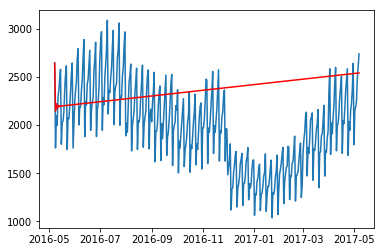

In [11]:
pred = sumOfItemsPredictions(7)

# ARIMA Model By Store-Item

In [4]:
# get predictions for sales for one item at one store and graph against actual sales
def individualItemsPredictions(storeNum, itemNum):
    myStore = train.loc[(train['store'] == storeNum) & (train['item'] == itemNum)]
    myStore.date = pd.to_datetime(myStore.date)
    myStore = myStore.set_index('date')
    myStore = myStore.drop(columns=['store', 'item'])
    num = int(0.67*len(myStore))
    myStoreTrain = myStore[:num]
    myStoreTest = myStore[num:]
    
    counter = -1
    predictions = []
    mse = []
    pdq = []
    for p in range(1,6):
        for d in range(1,2):
            for q in range(1, 8):
                #print(p, d, q)
                try:
                    model = ARIMA(myStoreTrain.astype(float), order=(p,d,q), freq='D')
                    model_fit = model.fit(disp=0)
                    counter += 1
                    pdq.append([p, d, q])
                    predictions.append(model_fit.forecast(len(myStoreTest)))
                    mse.append(mean_squared_error(myStoreTest['sales'], predictions[counter][0]))
                except:
                    pass
                    #print('Did not work')
                
    myIndex = mse.index(min(mse))
    print('Min MSE is: ' + str(mse[myIndex]) + ' with a P, D, Q of: ' + str(pdq[myIndex]))
    #print('MSE is: ' + str(mean_squared_error(myStoreTest['sales'], predictions[0])))
    #for x in range(100):
        #print('Predicted: ' + str(predictions[myIndex][0][x]))
        #print('Expected: ' + str(myStoreTest['sales'][x]))
    fig = pyplot.figure(figsize=(20,6))
    pyplot.plot(myStoreTest.index[:365], myStoreTest['sales'][:365])
    pyplot.plot(myStoreTest.index[:365], predictions[myIndex][0][:365], color='red')
    pyplot.show()
    return predictions

Min MSE is: 116.81154108157462 with a P, D, Q of: [2, 1, 6]


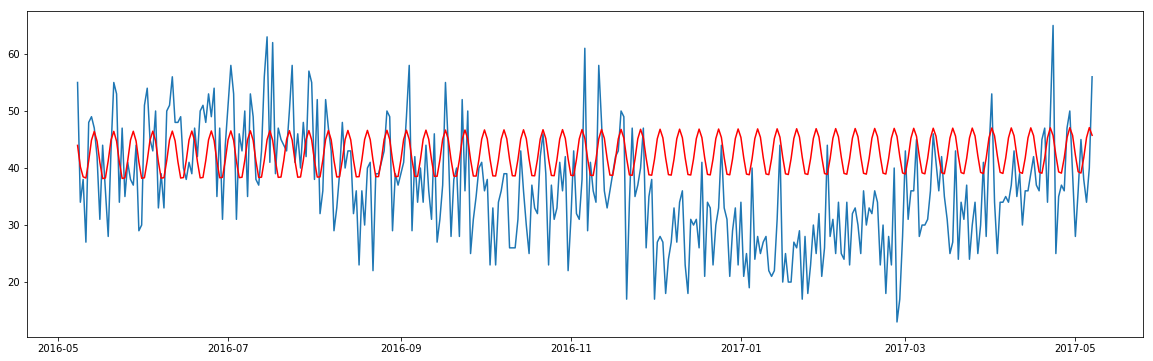

In [9]:
pred = individualItemsPredictions(7, 20)

# Winter Holts

In [5]:
# filter on store and item for new winter holts model
myStore = train.loc[(train['store'] == 7) & (train.item == 20)]
myStore.date = pd.to_datetime(myStore.date)
myStore = myStore.drop(columns=['store', 'item'])
myStore = myStore.set_index('date').groupby(['date']).sum()
num = int(0.67*len(myStore))
myStoreTrain = myStore[:num]
myStoreTest = myStore[num:]

In [6]:
# create winter holts seasonal model
model = ExponentialSmoothing(np.asarray(myStoreTrain['sales']) ,seasonal_periods=365, seasonal='add').fit()
predictions = model.forecast(len(myStoreTest))

MSE is: 9.480142649068489


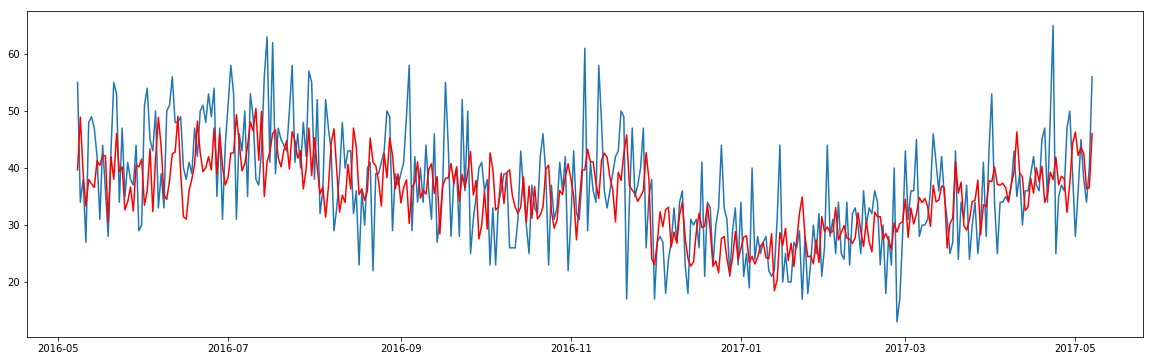

In [13]:
# view winter holts predictions and get error metrics - fbprophet is better
print("MSE is: " + str(np.sqrt(mean_squared_error(myStoreTest['sales'], predictions))))
fig = pyplot.figure(figsize=(20,6))
pyplot.plot(myStoreTest.index[:365], myStoreTest['sales'][:365])
pyplot.plot(myStoreTest.index[:365], predictions[:365], color='red')
pyplot.show()

# Monthly Residuals

In [14]:
# get residuals by month
myStoreTest['predictions'] = predictions
salesByMonth = myStoreTest['sales'].resample('M', how='sum')
predByMonth = myStoreTest['predictions'].resample('M', how='sum')
residByMonth = salesByMonth - predByMonth

86.8293761355637


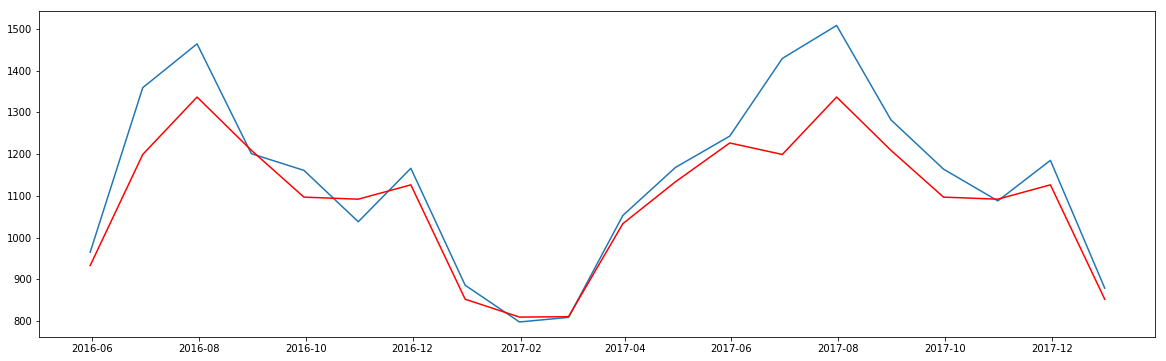

In [15]:
# plot residuals 
print(np.sqrt(mean_squared_error(salesByMonth, predByMonth)))
fig = pyplot.figure(figsize=(20,6))
pyplot.plot(salesByMonth.index, salesByMonth)
pyplot.plot(predByMonth.index, predByMonth, color='red')
pyplot.show()

In [ ]:
# look for patterns in residuals
residByMonth